In [1]:
import os
import copy
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
import sys
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
# from sklearn.metrics import classification_report, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
from PIL import Image
warnings.filterwarnings("ignore")

In [2]:
##### Removing the bad images

In [3]:
# from PIL import Image

# image_dir = "./data/wikiart_sample_large/"  # Update this with the path to your images

# def check_images_in_folder(folder_path):
#     bad_files = []
#     for filename in os.listdir(folder_path):
#         filepath = os.path.join(folder_path, filename)
#         if filename.endswith(".jpg") or filename.endswith(".png"):  # Add other file types if you have them
#             try:
#                 img = Image.open(filepath)  # open the image file
#                 img.verify()  # verify that it is an image
#             except (IOError, SyntaxError) as e:
#                 print('Bad file:', filepath)  # print out the names of corrupt or bad files
#                 bad_files.append(filepath)
#     return bad_files

In [4]:
# all_bad_files = []

# # Loop over each sub-folder in the main folder
# for class_folder in os.listdir(image_dir):
#     class_folder_path = os.path.join(image_dir, class_folder)
#     if os.path.isdir(class_folder_path):
#         bad_files = check_images_in_folder(class_folder_path)
#         all_bad_files.extend(bad_files)

In [5]:
# # Remove the bad files if any
# for bad_file in all_bad_files:
#     try:
#         os.remove(bad_file)
#         print(f"Removed bad file: {bad_file}")
#     except Exception as e:
#         print(f"Error occurred while deleting file : {bad_file}, error : {e}")

In [6]:
class RobustImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            path, target = self.samples[index]
            sample = self.loader(path)
            if self.transform is not None:
                sample = self.transform(sample)
            if self.target_transform is not None:
                target = self.target_transform(target)
            return sample, target
        except Exception as e:
            print(f"Skipping a problematic sample at index {index}, error: {e}")
            return torch.zeros([3, 224, 224]), -1  # Return dummy tensor and a dummy label

In [7]:
# Data Preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# Define the robust dataset
entire_dataset = RobustImageFolder(root='./data/wikiart_sample_large/', transform=transform)

# Now, you can calculate the lengths for splitting
total_size = len(entire_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

# Perform the split
train_dataset, val_dataset = random_split(entire_dataset, [train_size, val_size])

# Now, you can create your DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) #batch_size
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [9]:
# # dataset_path = './data/wikiart_sample/'
# dataset_path = './data/wikiart_sample_large/'
# dataset = ImageFolder(root=dataset_path, transform=transform)

In [10]:
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [11]:
class CustomResNet50(nn.Module):
    def __init__(self, dropout_rate=0.5,num_classes=27): #dropout_rate=0.5
        super(CustomResNet50, self).__init__()
        # Load the pre-trained ResNet-50 model
        self.resnet50_model = models.resnet50(pretrained=True)
        self.dropout = nn.Dropout(dropout_rate)

        # Modify its classifier to fit our number of classes
        num_ftrs = self.resnet50_model.fc.in_features
        self.resnet50_model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.resnet50_model(x)
        x = self.dropout(x)
        return x

In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [13]:
model = CustomResNet50()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001) # learning rate
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
print(f"Using device: {device}")

Using device: cuda


In [16]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 8
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        if inputs is None or labels is None or -1 in labels:
            print(f"Skipping a problematic batch at index {i}")
            continue

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        sys.stdout.write(f"\r[Epoch {epoch+1}, Mini-batch {i+1}] loss: {loss.item()}")
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)
    
    print(f"\nEpoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}\n")
    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            if inputs is None or labels is None or -1 in labels:
                print(f"Skipping a problematic batch in validation set")
                continue
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_losses.append(val_loss / len(val_loader))
    actual_accuracy = 100 * correct_val / total_val
    val_accuracies.append(actual_accuracy)
    
    print(f'Validation accuracy after epoch {epoch+1}: {actual_accuracy:.2f}%')
    
    if actual_accuracy > best_accuracy:
        best_accuracy = actual_accuracy
        torch.save(model, "wiki_TL_resnet_model_exp_large.pth")
        print(f"Best model saved with accuracy: {best_accuracy:.2f}%")
        
print("Training finished.")
print(f"Best model saved with accuracy: {best_accuracy:.2f}%")

[Epoch 1, Mini-batch 305] loss: 2.944681167602539Skipping a problematic sample at index 7228, error: broken data stream when reading image file
Skipping a problematic batch at index 305
[Epoch 1, Mini-batch 469] loss: 2.2802438735961914
Epoch 1/8, Loss: 2.808041898172293

Validation accuracy after epoch 1: 40.36%
Best model saved with accuracy: 40.36%
[Epoch 2, Mini-batch 33] loss: 2.644472360610962Skipping a problematic sample at index 7228, error: broken data stream when reading image file
Skipping a problematic batch at index 33
[Epoch 2, Mini-batch 469] loss: 3.2511365413665775
Epoch 2/8, Loss: 2.5331587379675176

Validation accuracy after epoch 2: 41.64%
Best model saved with accuracy: 41.64%
[Epoch 3, Mini-batch 205] loss: 2.4854576587677746Skipping a problematic sample at index 7228, error: broken data stream when reading image file
Skipping a problematic batch at index 205
[Epoch 3, Mini-batch 469] loss: 2.8403358459472656
Epoch 3/8, Loss: 2.360871736428885

Validation accuracy

In [25]:
# Calculate the most frequent label in the training set
label_counts = Counter([label for _, label in train_dataset])
most_common_label, frequency = label_counts.most_common(1)[0]

# Calculate the expected accuracy if no model (always predicting the most frequent label)
baseline_accuracy = (frequency / len(train_dataset)) * 100
print(f"Expected accuracy if no model: {baseline_accuracy:.2f}%")

Skipping a problematic sample at index 7228, error: broken data stream when reading image file
Expected accuracy if no model: 4.47%


In [26]:
label_to_style = {
    0: 'Abstract',
    1: 'Baroque',
    2: 'Cubism',
    3: 'Expressionism',
    4: 'Fauvism',
    5: 'Impressionism',
    6: 'Pop Art',
    7: 'Realism',
    8: 'Renaissance',
    9: 'Romanticism',
    10: 'Surrealism',
    11: 'Symbolism',
    12: 'Art Nouveau',
    13: 'Art Deco',
    14: 'Gothic',
    15: 'Neoclassicism',
    16: 'Post-Impressionism',
    17: 'Minimalism',
    18: 'Rococo',
    19: 'Byzantine',
    20: 'Contemporary',
    21: 'Photorealism',
    22: 'Pointillism',
    23: 'Futurism',
    24: 'Suprematism',
    25: 'Constructivism',
    26: 'Naive Art'
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

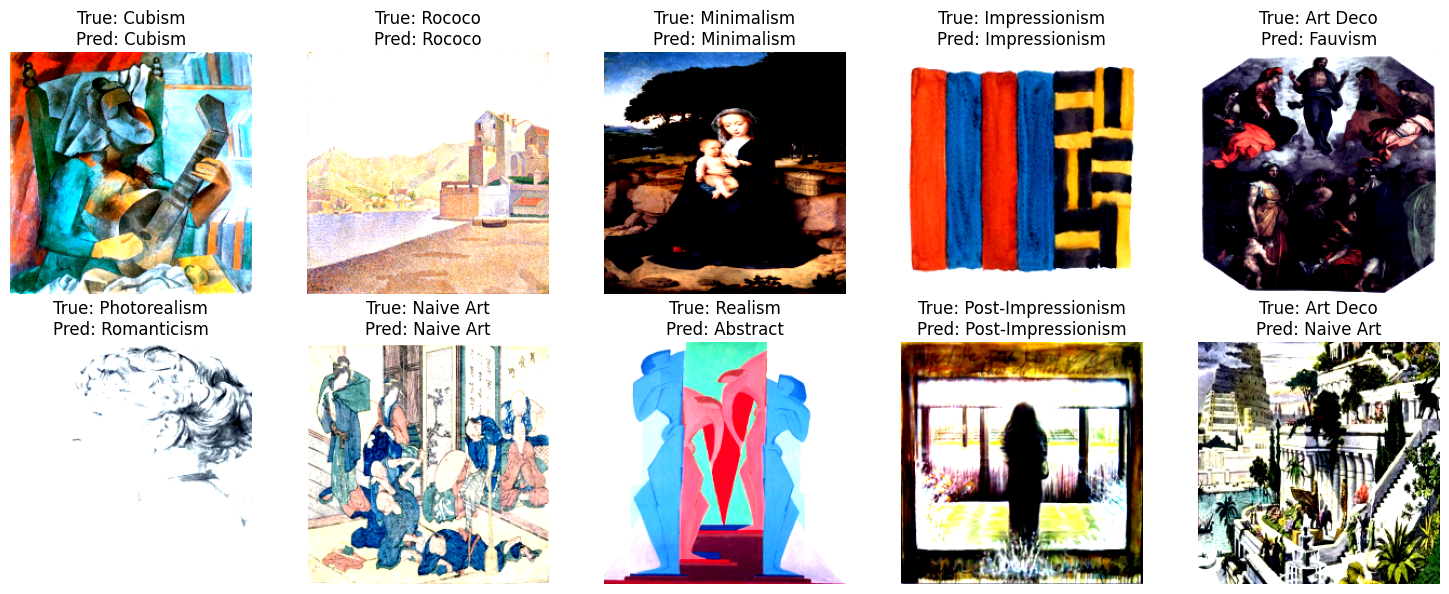

In [27]:
def imshow(img):
    img = img.cpu() / 2 + 0.5  # unnormalize and move to CPU
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Move the iterator and model to the same device (assuming model is on GPU)
dataiter = iter(val_loader)
images, labels = next(dataiter)
images, labels = images.to('cuda'), labels.to('cuda')

# Get the model output
model.eval()
outputs= model(images[:10])
_, predicted = torch.max(outputs.data, 1)

# Move images and labels back to CPU for visualization
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

# Show images with true and predicted labels
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # Adjusted for a 2x5 grid

for i in range(10):  # Loop 10 times for 10 images
    row = i // 5
    col = i % 5
    img = images[i] / 2 + 0.5  # unnormalize
    img = img.numpy()
    axs[row, col].imshow(np.transpose(img, (1, 2, 0)))

    true_label = label_to_style[int(labels[i].item())]  # Make sure label_to_style is defined
    predicted_label = label_to_style[int(predicted[i].item())]

    axs[row, col].set_title(f"True: {true_label}\nPred: {predicted_label}")
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

In [28]:
all_labels = []
all_preds = []
model.eval()

with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the same device as the model (assuming it's on GPU)
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        outputs = model(inputs[:10])
        predicted_labels = labels[:10]
        _, predicted = torch.max(outputs.data, 1)

        # Move predicted_labels and predicted back to CPU for further processing
        predicted_labels = predicted_labels.cpu()
        predicted = predicted.cpu()

        all_labels.extend(predicted_labels)
        all_preds.extend(predicted)

# Convert to Python integers
all_labels = [label.item() for label in all_labels]
all_preds = [pred.item() for pred in all_preds]

# Calculate the confusion matrix
print("Confusion Matrix:")
conf_mat = confusion_matrix(all_labels, all_preds)

Confusion Matrix:


In [29]:
print("Classification Report:")
print(classification_report(all_labels, all_preds))

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.38      0.39        45
           1       0.64      0.54      0.58        13
           2       0.64      0.75      0.69        12
           3       0.23      0.33      0.27        36
           4       0.34      0.19      0.25        57
           5       0.73      0.78      0.76        46
           6       0.54      0.52      0.53        56
           7       0.46      0.49      0.47        55
           8       0.52      0.29      0.37        38
           9       0.18      0.20      0.19        49
          10       0.51      0.47      0.49        51
          11       0.48      0.33      0.39        40
          12       0.33      0.35      0.34        46
          13       0.63      0.28      0.39        43
          14       0.56      0.89      0.68        44
          15       0.53      0.34      0.42        47
          16       0.42      0.42      0.42        40
    

In [30]:
# print("Classification Report:")
# print(classification_report(all_labels, all_preds, target_names=sorted(list(label_to_style.values()))))

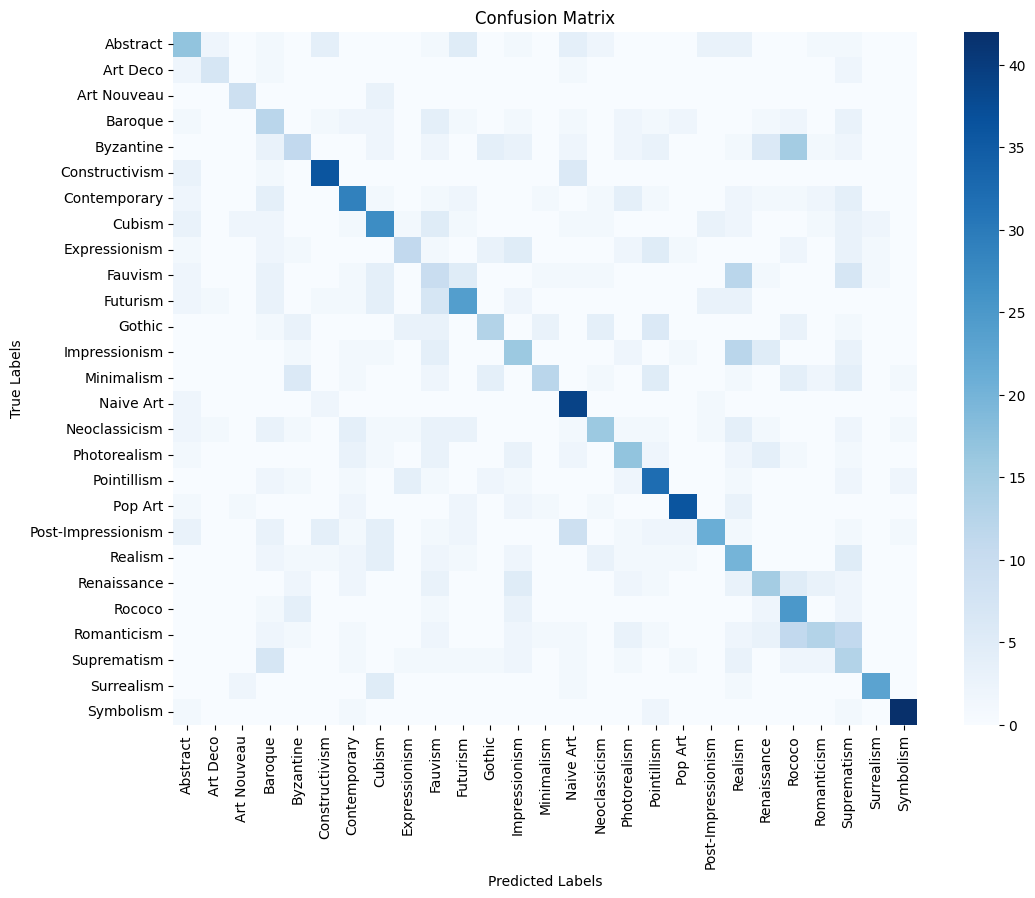

In [31]:
unique_styles = sorted(list(label_to_style.values()))

plt.figure(figsize=(12, 9))
sns.heatmap(conf_mat, fmt='d', cmap='Blues',
            xticklabels=unique_styles,
            yticklabels=unique_styles)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

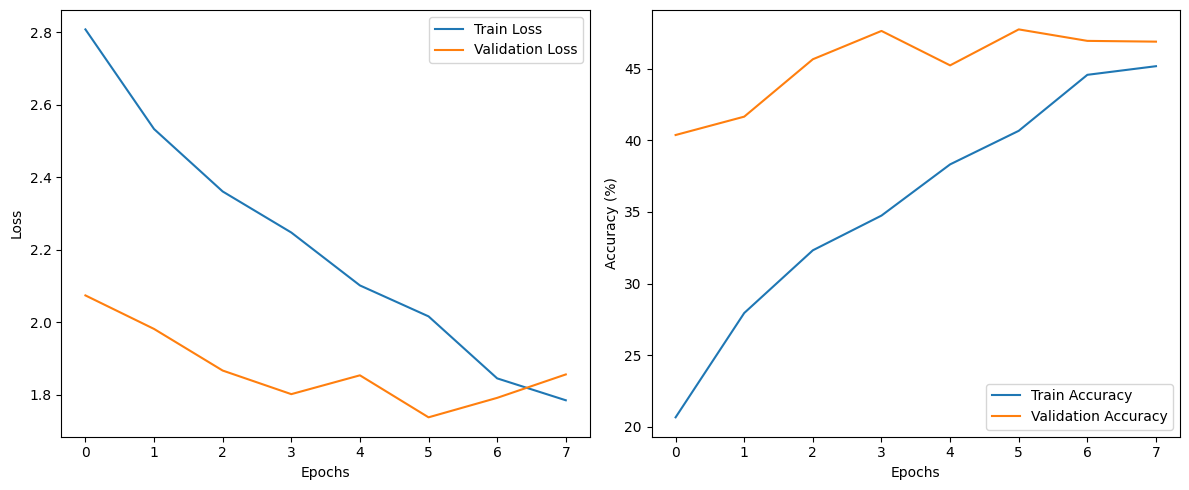

In [32]:
# Plotting
plt.figure(figsize=(12, 5))

# Train and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Train and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()